In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from math import sqrt

### Set Up
The below simply defines a learning problem. We'll do binary classification, but add some noisiness to the labels to be realistic. We'll define some useful features and some useless ones

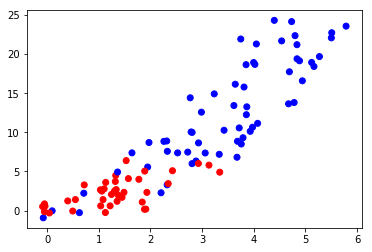

In [3]:
N = 100 # Number of training examples
D = 2 # Number of features
label_noise = 0.1

np.random.seed(47)

# this is the binary function we want our logistic regression to learn (but it is noisy)
def f(x):
    oops = np.random.uniform(0,1) <= label_noise
    return 1 if (x > 2.5 or oops) else 0 

def feature1(x):
    # this is a useful feature (albeit with some noise)
    return x + np.random.uniform(-1, 1, x.shape)
    
def feature2(x):
    # this is a useful feature (albeit with some noise)
    return np.power(x, 2) + np.random.uniform(-1, 1, x.shape)

# underlying set of points used to generate data
x = np.random.uniform(0, 5, N)  
# labels that we will try to predict
y = [f(xx) for xx in x]

# features
X = np.zeros((N, D)) 
X[:, 0] = feature1(x)
X[:, 1] = feature2(x)

# plot the data
plt.scatter(X[:, 0], X[:, 1], color=['r' if yy == 0 else 'b' for yy in y])
plt.show()

### Train/Test Splits and Cross-Validation

In [4]:
# Basic train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = LogisticRegression()
clf.fit(X_train, y_train)
print("Regular train/test")
print("Train Accuracy", clf.score(X_train, y_train))
print("Test Accuracy",clf.score(X_test, y_test))
print()

# Evaluating with cross validation (gives better/more stable prediction of test performance)
n_fold = 10
train_accs = []
accs = []
for _ in range(n_fold):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    train_accs.append(clf.score(X_train, y_train))
    accs.append(clf.score(X_test, y_test))
    
print("Cross-validation train/test")
print("Train: ", sum(train_accs)/n_fold)
print("Test: ", sum(accs)/n_fold)
#plt.scatter(np.arange(n_fold), accs)
#plt.axhline(sum(accs)/n_fold, linestyle='--', color='k')
#plt.show()

Regular train/test
('Train Accuracy', 0.90000000000000002)
('Test Accuracy', 0.90000000000000002)
()
Cross-validation train/test
('Train: ', 0.88555555555555576)
('Test: ', 0.84000000000000019)


### Illustrating decision boundaries in logistic regression
The below is to illustrate the relationship between the parameters set in the logistic regression (same parameters we had in linear regression) and the way the classification decision is determined (different than linear regression)

In [7]:
print(clf.coef_)

[[-0.36407676  0.53577935]]


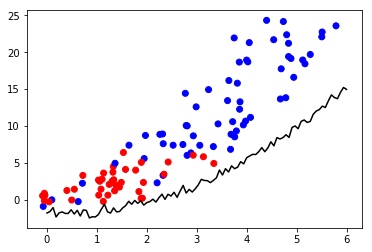

In [9]:
# these are the feature extractors we used to train our original model
feature_fns = [feature1, feature2]

# generate evenly-spaced points so we can plot the curve
xsim = np.linspace(0,6,100)
# reconstruct the y = dot(w,x) + b prediction based on the learned parameters
learned = np.zeros(xsim.shape)
for i, w in enumerate(clf.coef_[0]):
    fn = feature_fns[i]
    learned += (w * fn(xsim)) 
learned += clf.intercept_ 

# Optionally, plot scatter to show that this line is
# *not* a desicion boundary for the logistic regression
plt.scatter(X[:, 0], X[:, 1], color=['r' if yy == 0 else 'b' for yy in y])

plt.plot(xsim, learned, color='k')
plt.show()

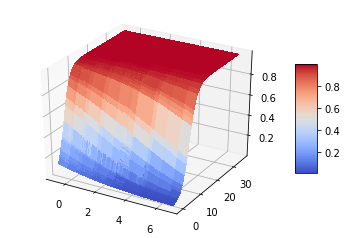

In [11]:
# Before performing classification, we pipe the linear regression through a sigmoid function
# which we use to produce the decision boundary

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def learned_linreg(clf, feats):
    pred = 0
    feature_fns = [feature1, feature2]
    for i, w in enumerate(clf.coef_[0]):
        pred += (w * feats[i]) 
    pred += clf.intercept_
    return pred

fig = plt.figure()
ax = fig.gca(projection='3d')
Xg, Yg = np.meshgrid(feature1(xsim), feature2(xsim))
#Zg = learned_linreg(clf, [Xg, Yg])
Zg = sigmoid(learned_linreg(clf, [Xg, Yg]))
surf = ax.plot_surface(Xg, Yg, Zg, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

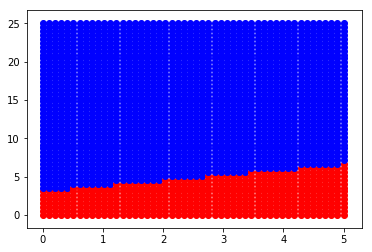

In [13]:
# You can see the decision boundary by evaluating the above at arbitry points in the feature
# space and seeing which points lead to positive predictions and which lead to negative ones
n_points = 50
a = 1 # transparency of points, for aesthetics
feature_fns = [feature1, feature2]

#plt.scatter(X_train[:, 0], X_train[:, 1], color=['r' if yy == 0 else 'b' for yy in y_train])
#plt.scatter(X_test[:, 0], X_test[:, 1], color=['r' if yy == 0 else 'b' for yy in y_train])

for f1 in np.linspace(0,5,n_points): # possible values of feature1
    for f2 in np.linspace(0,25,n_points): # possible values of feature2
        pred = sigmoid(learned_linreg(clf, [f1, f2]))
        c = 'r' if pred < 0.5 else 'b'
        plt.scatter(f1, f2, marker='o', color=c, alpha=a)

plt.show()